In [1]:
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch

# read the config file
config_file = "fhn.json"
solver = pkdl.ParamKoopmanDLSolverWrapper(config_file)

# set up the grid
Nx = 10
x_max = 10
x_min = -10
x_step = (x_max - x_min) / Nx
x_grid = torch.linspace(x_min, x_max, Nx).unsqueeze(0)

def vw_sample_func(row_size, col_size):
  assert (col_size == Nx * 2)
  x_grid_data = x_grid.expand(row_size, Nx)
  torch.manual_seed(0)
  a = torch.randint(0, 20, (1,)).item()
  v = torch.sin((a * torch.pi * x_grid_data)/10 + torch.pi/2)
  w = torch.zeros(v.size())
  return torch.cat([v, w], dim=1)

# set up the solver
nontrain_func = lambda x: torch.cat([torch.ones((x.shape[0], 1)), x], dim=1)
solver.setup(nontrain_func, vw_sample_func)
K = solver.solve()

CUDA is available. GPU is being used.


2024-11-06 14:31:07,973 PKoopmanDL: [INFO] [ParamKoopmanDLSolver] Solving...
Training: 100%|██████████| 30/30 [04:45<00:00,  9.53s/it, train_loss=4.63e-05, val_loss=7.26e-06]


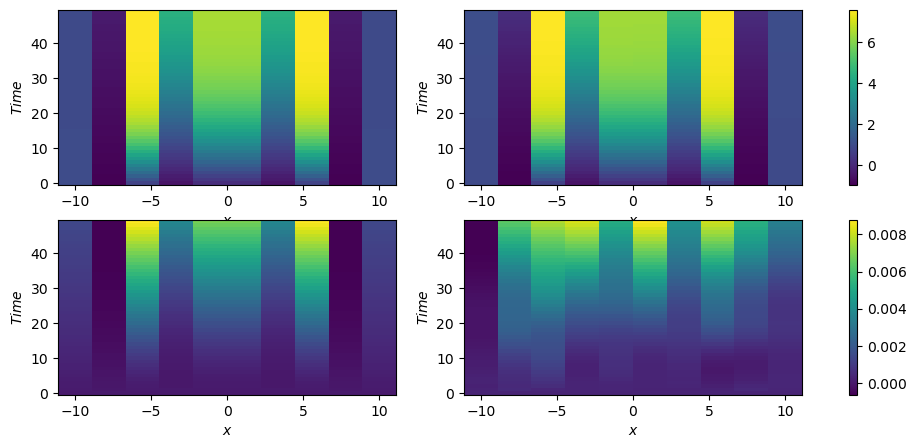

In [4]:
# predict
param = torch.tensor([[0.5]]).detach()
dataset_predict = pkdl.ODEDataSet(solver.ode, solver.flowmap, vw_sample_func)
dataset_predict.generate_data(1, solver.traj_len, solver.x_min, solver.x_max, param)
x0 = torch.unsqueeze(dataset_predict.data_x[0], dim=0)
state_pos = list(range(1, 21))
p = K.predict(param, x0, solver.dictionary, state_pos, solver.dim_nontrain, solver.traj_len).detach()
x_est_traj = p[0, :, :]
t_grid = np.arange(0, solver.traj_len)
x_traj = solver.flowmap.generate_traj_data(solver.ode, x0, param, solver.traj_len).detach()

X, Y = np.meshgrid(x_grid, t_grid)
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(12,5))  
c1 = axs[0, 0].pcolormesh(X, Y, x_traj[:, :Nx], shading='auto')
axs[0, 0].set_xlabel(r"$x$")
axs[0, 0].set_ylabel(r"$Time$")
c2 = axs[0, 1].pcolormesh(X, Y, x_est_traj[:, 1:Nx+1], shading='auto')
axs[0, 1].set_xlabel(r"$x$")
axs[0, 1].set_ylabel(r"$Time$")
c3 = axs[1, 0].pcolormesh(X, Y, x_traj[:, Nx:2*Nx], shading='auto')
axs[1, 0].set_xlabel(r"$x$")
axs[1, 0].set_ylabel(r"$Time$")
c4 = axs[1, 1].pcolormesh(X, Y, x_est_traj[:, Nx+1:2*Nx+1], shading='auto')
axs[1, 1].set_xlabel(r"$x$")
axs[1, 1].set_ylabel(r"$Time$")
cbar_row1 = fig.colorbar(c1, ax=axs[0, :])
cbar_row2 = fig.colorbar(c3, ax=axs[1, :])
plt.show()